In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.widgets import Button

/bin/bash: line 1: fg: no job control


## Algorithm

In [ ]:
class CheckerBoardDetector:
    def __init__(self, yolo_model_path, board_size=8):
        self.board_size = board_size
        self.yolo_model = YOLO(yolo_model_path)
        self.board_corners = None
        self.homography_matrix = None
        self.warped_image = None

    def detect_board_corners(self, image):
        """Detects board corners using HoughLinesP method."""
        corners = self._detect_via_hough_linesP(image)
        
        if corners is None:
            print("HoughLinesP detection failed. Using image boundaries as corners.")
            h, w = image.shape[:2]
            margin = 20
            corners = np.array([
                [margin, margin], 
                [w - margin, margin], 
                [w - margin, h - margin], 
                [margin, h - margin]
            ], dtype=np.float32)

        self.board_corners = self._order_corners(corners)
        return self.board_corners

    def _detect_via_hough_linesP(self, image):
        """Detects board using HoughLinesP to find grid line segments."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bilateralFilter(gray, 9, 75, 75)
        
        thresh = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blockSize=11,
            C=2
        )
        
        edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 60, minLineLength=30, maxLineGap=15)
        
        if lines is None or len(lines) < 4:
            return None

        points = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            points.append([x1, y1])
            points.append([x2, y2])

        if len(points) < 4:
            return None

        points = np.array(points, dtype=np.float32)
        hull = cv2.convexHull(points)
        epsilon = 0.08 * cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, epsilon, True)
        corners = approx.reshape(-1, 2).astype(np.float32)
        
        if len(corners) >= 4:
            hull = cv2.convexHull(corners)
            corners = hull.reshape(-1, 2).astype(np.float32)
        
        if len(corners) == 4:
            return corners
        
        return None

    def _order_corners(self, pts):
        """Orders corners consistently: TL, TR, BR, BL."""
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]  # Top-left
        rect[2] = pts[np.argmax(s)]  # Bottom-right
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  # Top-right
        rect[3] = pts[np.argmax(diff)]  # Bottom-left
        return rect

    def set_corners(self, corners):
        """Manually set board corners from UI."""
        self.board_corners = np.array(corners, dtype=np.float32)

    def get_matrix_from_image(self, image, scale_factor=9):
        """Warps the image and runs YOLO to detect pieces."""
        if self.board_corners is None:
            raise ValueError("Board corners not set. Run detect_board_corners first.")

        output_size = int(self.board_size * 100 * scale_factor)
        dst_pts = np.array([
            [0, 0],
            [output_size, 0],
            [output_size, output_size],
            [0, output_size]
        ], dtype=np.float32)

        self.homography_matrix, _ = cv2.findHomography(self.board_corners, dst_pts)
        self.warped_image = cv2.warpPerspective(image, self.homography_matrix, (output_size, output_size))

        results = self.yolo_model(self.warped_image, conf=0.25, verbose=False)
        
        detections = []
        if results and results[0].boxes:
            for box in results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
                class_id = int(box.cls[0].item())
                conf = box.conf[0].item()
                detections.append({'cls': class_id, 'conf': conf, 'cx': cx, 'cy': cy})

        matrix = np.zeros((self.board_size, self.board_size), dtype=int)
        cell_size = output_size / self.board_size
        candidates = {}

        for det in detections:
            col = int(det['cx'] // cell_size)
            row = int(det['cy'] // cell_size)

            if 0 <= col < self.board_size and 0 <= row < self.board_size:
                if (row, col) not in candidates:
                    candidates[(row, col)] = []
                candidates[(row, col)].append(det)

        for (r, c), dets in candidates.items():
            best = max(dets, key=lambda x: x['conf'])
            matrix[r, c] = best['cls'] + 1

        return matrix, detections

## Up-view Photo

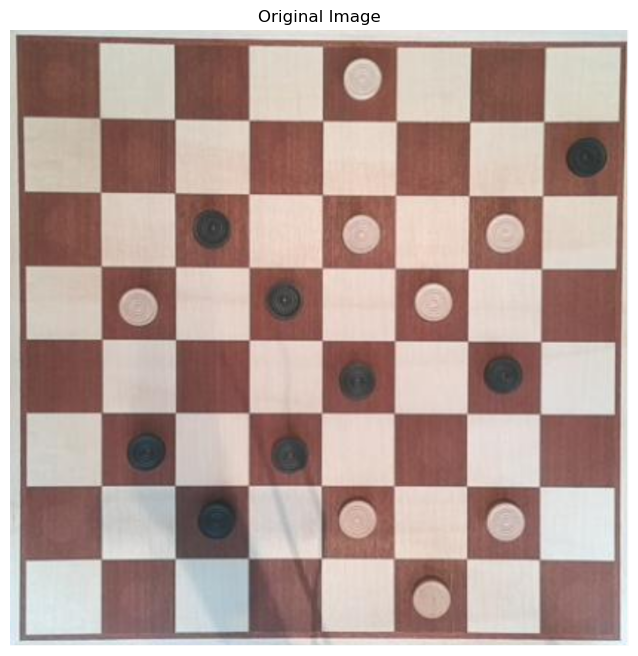

In [ ]:
image_path = "board_image.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model_path = "../YoloPreTrained/resultados/runs_3_classes/detect/checkers_yolo12/weights/best.pt"
detector = CheckerBoardDetector(model_path, board_size=8)

# Display original image
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

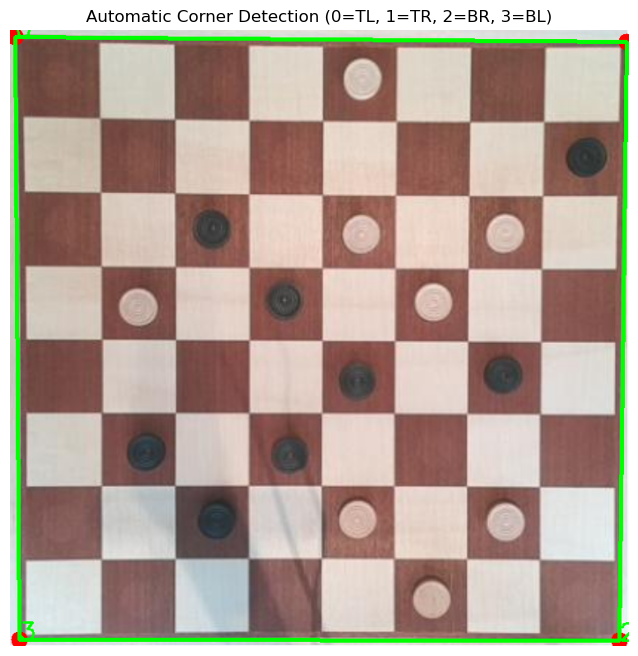

Detected Corners: [[          6           8]
 [        748          14]
 [        739         741]
 [         11         740]]


In [45]:
corners = detector.detect_board_corners(image)

# Visualize detected corners
img_with_corners = image_rgb.copy()
if corners is not None:
    # Draw corners
    for i, corner in enumerate(corners):
        cv2.circle(img_with_corners, tuple(corner.astype(int)), 10, (255, 0, 0), -1)
        cv2.putText(img_with_corners, str(i), tuple(corner.astype(int)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Draw board outline
    pts = corners.astype(np.int32).reshape((-1, 1, 2))
    cv2.polylines(img_with_corners, [pts], True, (0, 255, 0), 3)

plt.figure(figsize=(10, 8))
plt.imshow(img_with_corners)
plt.title('Automatic Corner Detection (0=TL, 1=TR, 2=BR, 3=BL)')
plt.axis('off')
plt.show()

print("Detected Corners:", corners)

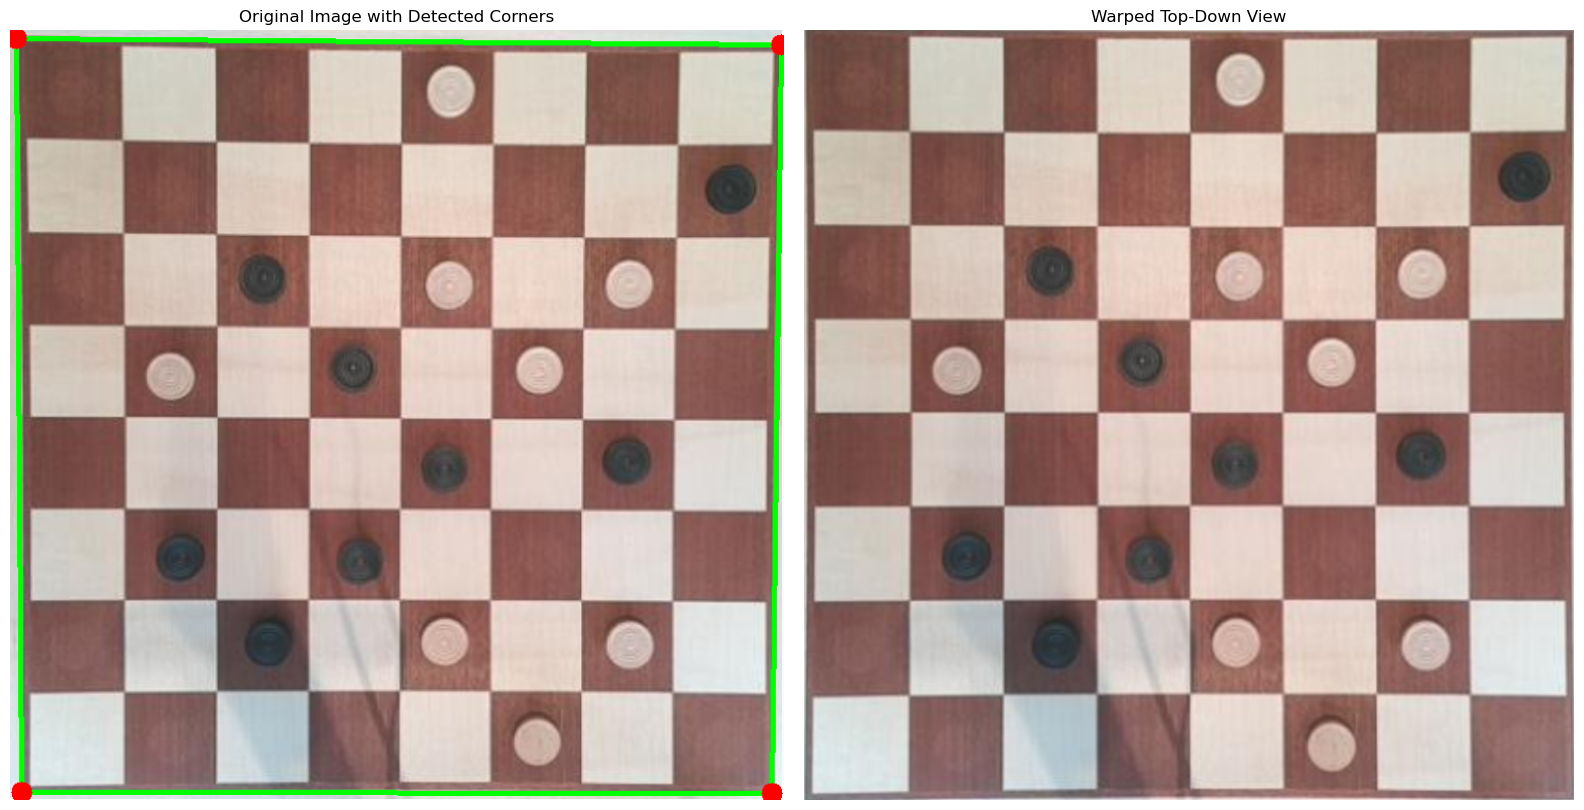

In [47]:
matrix, detections = detector.get_matrix_from_image(image)

# Display warped image
warped_rgb = cv2.cvtColor(detector.warped_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original with corners
img_final = image_rgb.copy()
pts = detector.board_corners.astype(np.int32).reshape((-1, 1, 2))
cv2.polylines(img_final, [pts], True, (0, 255, 0), 3)
for i, corner in enumerate(detector.board_corners):
    cv2.circle(img_final, tuple(corner.astype(int)), 10, (255, 0, 0), -1)

axes[0].imshow(img_final)
axes[0].set_title('Original Image with Detected Corners')
axes[0].axis('off')

# Warped board
axes[1].imshow(warped_rgb)
axes[1].set_title('Warped Top-Down View')
axes[1].axis('off')

plt.tight_layout()
plt.show()

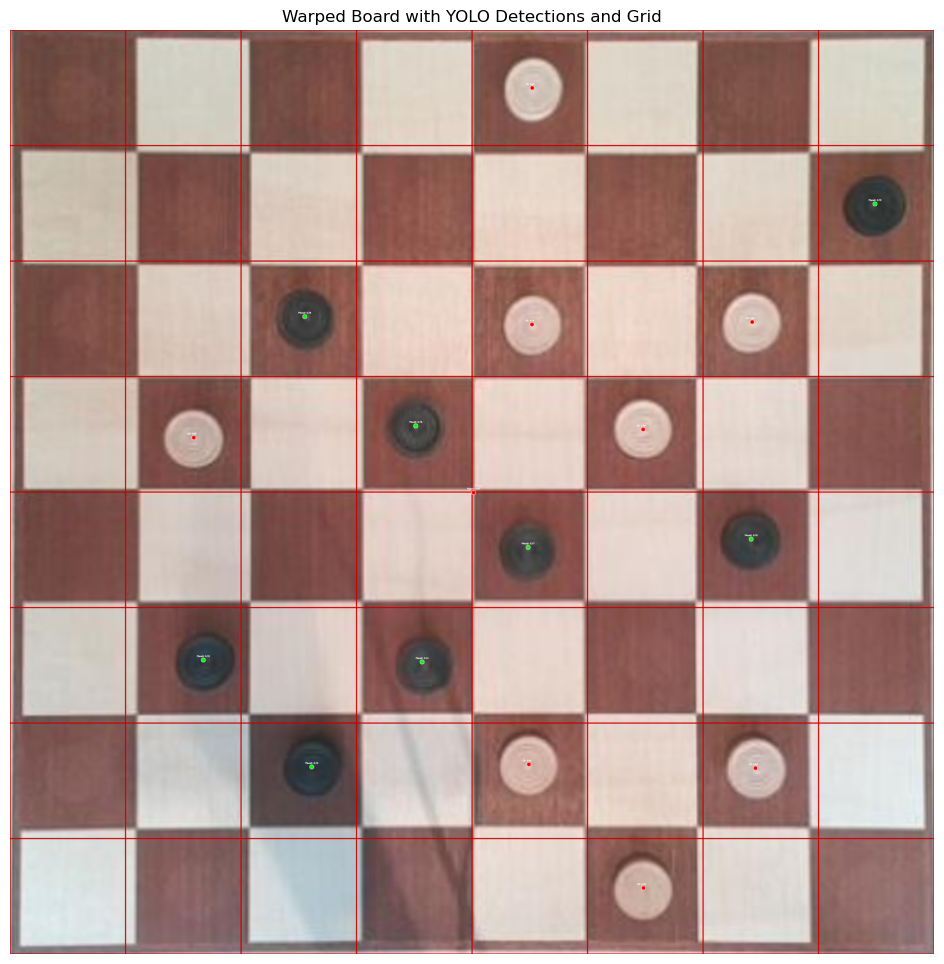

In [51]:
warped_with_detections = warped_rgb.copy()
output_size = warped_rgb.shape[0]
cell_size = output_size / detector.board_size

for i in range(detector.board_size + 1):
    pos = int(i * cell_size)
    cv2.line(warped_with_detections, (pos, 0), (pos, output_size), (200, 0, 0), 8)
    cv2.line(warped_with_detections, (0, pos), (output_size, pos), (200, 0, 0), 8)

class_names = ['Piece1', 'Piece2']
colors = [(255, 0, 0), (0, 255, 0)]

for det in detections:
    cx, cy = int(det['cx']), int(det['cy'])
    cls = det['cls']
    conf = det['conf']
    
    color = colors[cls % len(colors)]
    cv2.circle(warped_with_detections, (cx, cy), 15, color, -1)
    cv2.circle(warped_with_detections, (cx, cy), 17, (255, 255, 255), 2)
    
    # Add label
    label = f"{class_names[cls] if cls < len(class_names) else f'C{cls}'}: {conf:.2f}"
    cv2.putText(warped_with_detections, label, (cx - 50, cy - 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

plt.figure(figsize=(12, 12))
plt.imshow(warped_with_detections)
plt.title('Warped Board with YOLO Detections and Grid')
plt.axis('off')
plt.show()

## Angled Photo

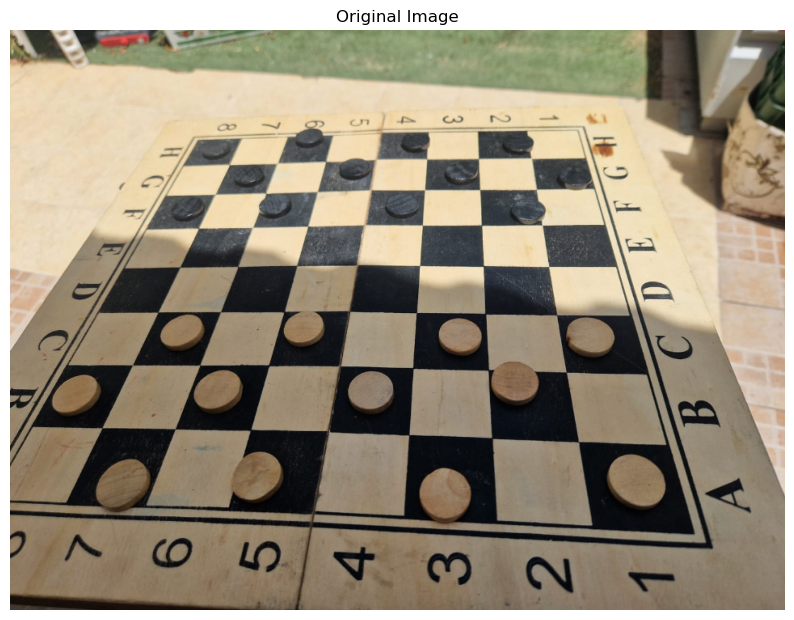

In [53]:
image = cv2.imread('board_image_angle_view.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

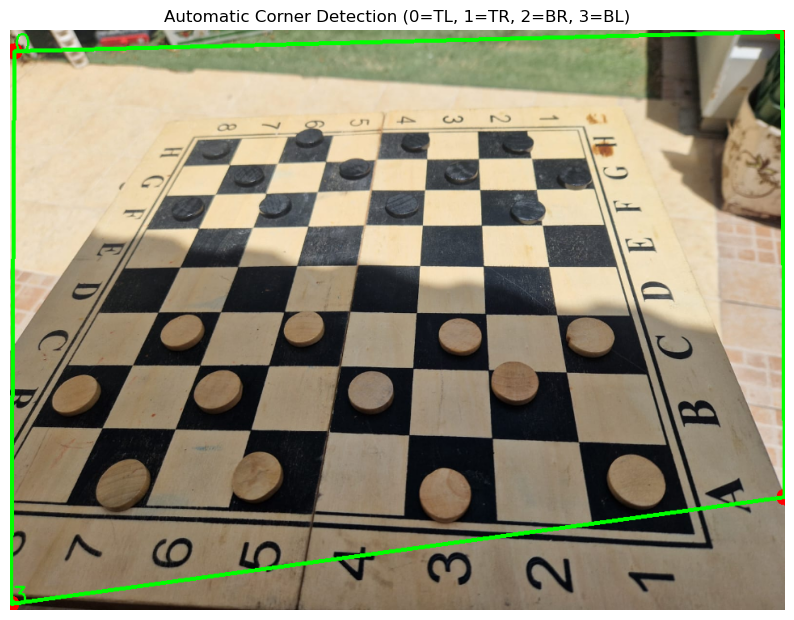

Detected Corners: [[          5          27]
 [        955           3]
 [        958         578]
 [          1         710]]


In [54]:
corners = detector.detect_board_corners(image)

# Visualize detected corners
img_with_corners = image_rgb.copy()
if corners is not None:
    # Draw corners
    for i, corner in enumerate(corners):
        cv2.circle(img_with_corners, tuple(corner.astype(int)), 10, (255, 0, 0), -1)
        cv2.putText(img_with_corners, str(i), tuple(corner.astype(int)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Draw board outline
    pts = corners.astype(np.int32).reshape((-1, 1, 2))
    cv2.polylines(img_with_corners, [pts], True, (0, 255, 0), 3)

plt.figure(figsize=(10, 8))
plt.imshow(img_with_corners)
plt.title('Automatic Corner Detection (0=TL, 1=TR, 2=BR, 3=BL)')
plt.axis('off')
plt.show()

print("Detected Corners:", corners)

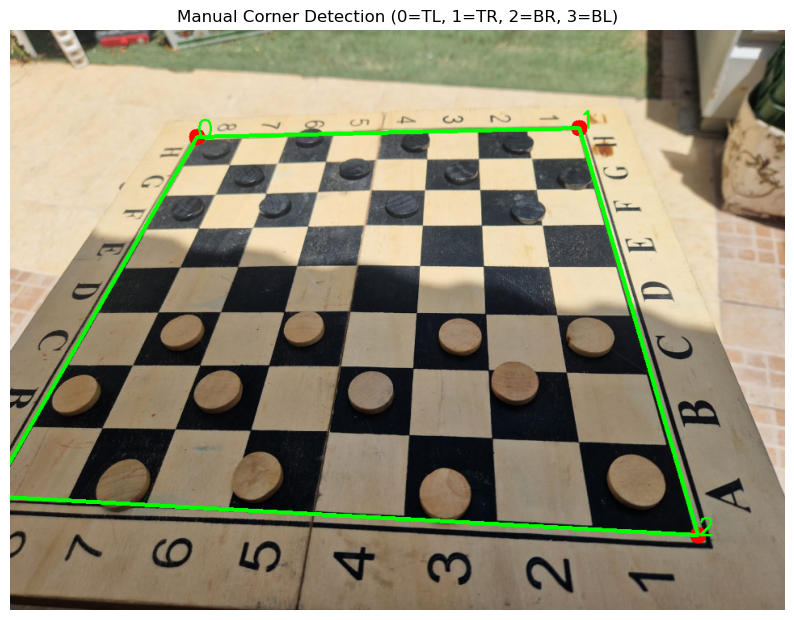

In [65]:
corners_manual = [[231.23, 133.19],
                  [704.33, 122.54],
                  [851.38, 625.48],
                  [-25.573, 577.53]]

# Convert to numpy array first
corners_manual = np.array(corners_manual, dtype=np.float32)

# Visualize detected corners
img_with_corners_manual = image_rgb.copy()

# Draw corners
for i, corner in enumerate(corners_manual):
    cv2.circle(img_with_corners_manual, tuple(corner.astype(int)), 10, (255, 0, 0), -1)
    cv2.putText(img_with_corners_manual, str(i), tuple(corner.astype(int)), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Draw board outline
pts = corners_manual.astype(np.int32).reshape((-1, 1, 2))
cv2.polylines(img_with_corners_manual, [pts], True, (0, 255, 0), 3)

plt.figure(figsize=(10, 8))
plt.imshow(img_with_corners_manual)
plt.title('Manual Corner Detection (0=TL, 1=TR, 2=BR, 3=BL)')
plt.axis('off')
plt.show()

detector.set_corners(corners_manual)


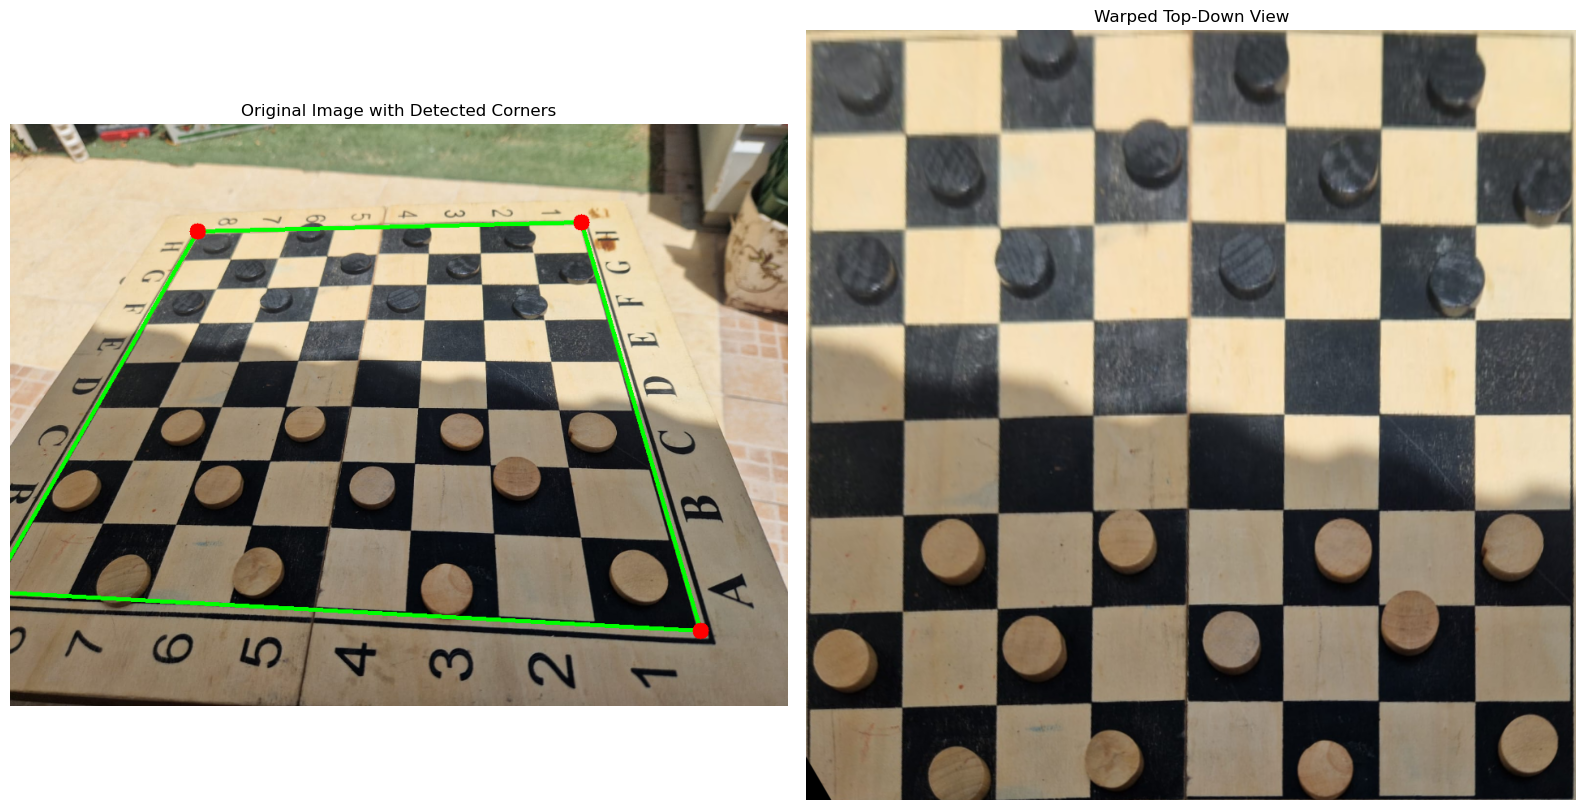

In [66]:
matrix, detections = detector.get_matrix_from_image(image)

# Display warped image
warped_rgb = cv2.cvtColor(detector.warped_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original with corners
img_final = image_rgb.copy()
pts = detector.board_corners.astype(np.int32).reshape((-1, 1, 2))
cv2.polylines(img_final, [pts], True, (0, 255, 0), 3)
for i, corner in enumerate(detector.board_corners):
    cv2.circle(img_final, tuple(corner.astype(int)), 10, (255, 0, 0), -1)

axes[0].imshow(img_final)
axes[0].set_title('Original Image with Detected Corners')
axes[0].axis('off')

# Warped board
axes[1].imshow(warped_rgb)
axes[1].set_title('Warped Top-Down View')
axes[1].axis('off')

plt.tight_layout()
plt.show()

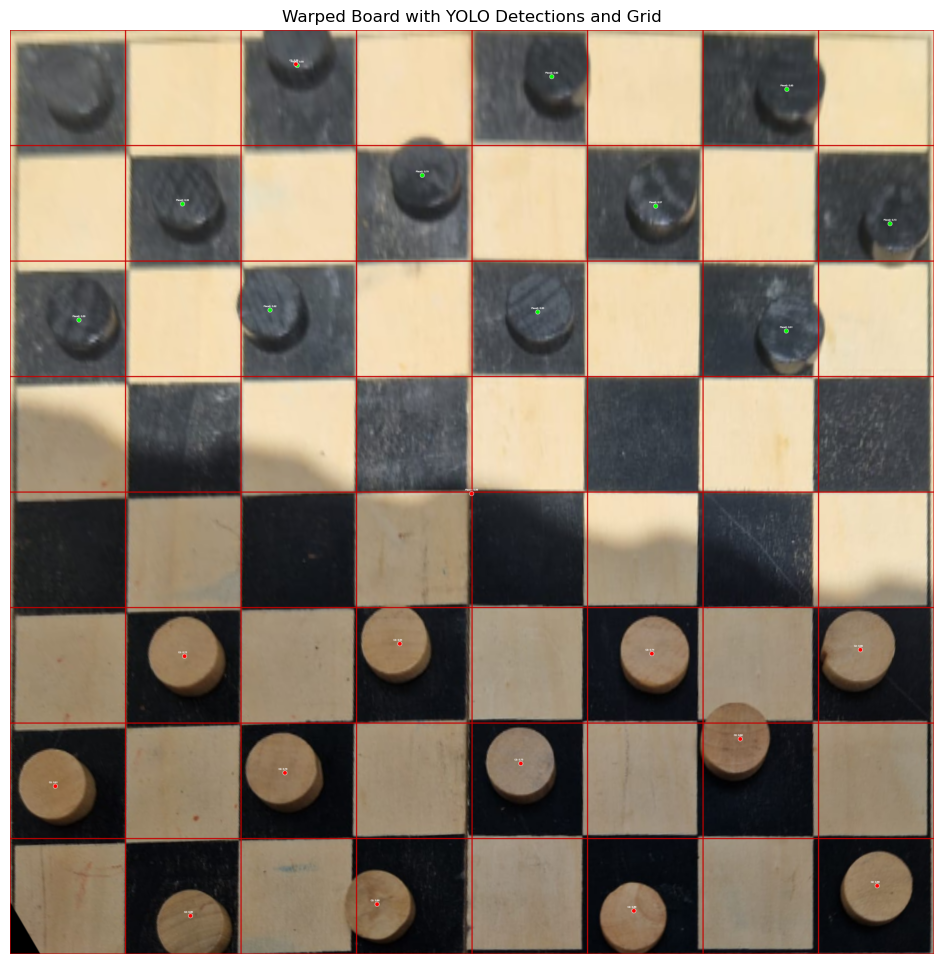

In [67]:
warped_with_detections = warped_rgb.copy()
output_size = warped_rgb.shape[0]
cell_size = output_size / detector.board_size

for i in range(detector.board_size + 1):
    pos = int(i * cell_size)
    cv2.line(warped_with_detections, (pos, 0), (pos, output_size), (200, 0, 0), 8)
    cv2.line(warped_with_detections, (0, pos), (output_size, pos), (200, 0, 0), 8)

class_names = ['Piece1', 'Piece2']
colors = [(255, 0, 0), (0, 255, 0)]

for det in detections:
    cx, cy = int(det['cx']), int(det['cy'])
    cls = det['cls']
    conf = det['conf']
    
    color = colors[cls % len(colors)]
    cv2.circle(warped_with_detections, (cx, cy), 15, color, -1)
    cv2.circle(warped_with_detections, (cx, cy), 17, (255, 255, 255), 2)
    
    # Add label
    label = f"{class_names[cls] if cls < len(class_names) else f'C{cls}'}: {conf:.2f}"
    cv2.putText(warped_with_detections, label, (cx - 50, cy - 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

plt.figure(figsize=(12, 12))
plt.imshow(warped_with_detections)
plt.title('Warped Board with YOLO Detections and Grid')
plt.axis('off')
plt.show()